# Final project

## Reasearch questions

Which community split is best (born house or married house)?

Compare to the community split obtained by the algorithm.

Which communities are most connected?

Find sentiments score for each community.

Do the most connected communities have similar sentiment scores?

## Loading data


In [63]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community
import json

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [64]:
if (not os.path.exists('files/characters.json')) or (not os.path.exists('files/houses.csv')) or (not os.path.exists('files/wiki_texts/')):
    # create paths
    if not os.path.exists('files'):
        os.mkdir('files')
    if not os.path.exists('files/wiki_texts'):
        os.mkdir('files/wiki_texts')

    baseurl = "https://gameofthrones.fandom.com/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    site = 'Game_of_Thrones'
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": site
    }

    # Send the API request to retrieve the content
    response = requests.get(baseurl, params=params)
    data = response.json()

    # Extract and print the text content
    page_id = list(data['query']['pages'].keys())[0]
    text_content = data['query']['pages'][page_id]['revisions'][0]['*']
    cast = text_content[text_content.find("==Cast=="):text_content.find("==Crew==")]
    #print(cast)
    # find all lines starting with *
    lines = cast.split('\n')
    lines = [line for line in lines if line.startswith('*')]
    lines_chars = [line[line.find("as "):] for line in lines]
    # extract the second name in [[name]]
    pattern = r'\[{2}(.+?)\]{2}'
    names = [re.findall(pattern, line)[0] for line in lines_chars]
    names = [name.split('|')[0] for name in names]

    characters = {}
    houses = []
    for name in names:
        print(name)
        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": name
        }

        # Send the API request to retrieve the content
        response = requests.get(baseurl, params=params)
        data = response.json()

        # Extract and print the text content
        page_id = list(data['query']['pages'].keys())[0]
        text_content = data['query']['pages'][page_id]['revisions'][0]['*']
        # save text content to file
        with open('files/wiki_texts/' + name + '.txt', 'w') as f:
            f.write(text_content)
        # find line with | House
        try:
            house_line = re.findall(r'\| House (.+)', text_content)[0]
            houses_list = re.findall(pattern, house_line)
            if len(houses_list) == 0:
                houses_list = ['No house']
        except:
            houses_list = ['No house']
            

        characters[name] = []
        for house in houses_list:
            house = house.split('|')[0]
            if house == 'Legitimization':
                continue
            if house == 'House Baratheon of King\'s Landing' or house == 'House Baratheon of Dragonstone':
                house = 'House Baratheon'
            if house not in houses:
                houses.append(house)
            if house not in characters[name]:
                characters[name].append(house)
        print(characters[name])

    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)
    # save houses to csv
    houses_df = pd.DataFrame(houses, columns=['House'])
    houses_df.to_csv('files/houses.csv', index=False)
else:
    print('Loading characters and houses from files')
    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)
    houses_df = pd.read_csv('files/houses.csv')
    houses = list(houses_df['House'])


Loading characters and houses from files


In [65]:
if (not os.path.exists('files/di_G.gexf')) and (not os.path.exists('files/di_G_with_house.gexf')):
    
    pattern = r'\[{2}(.+?)\]{2}'
    
    di_G = nx.DiGraph()
    di_G_with_house = nx.DiGraph()

    for name in characters:
        houses_list = characters[name]
        houses_string = ', '.join(houses_list)
        di_G.add_node(name, houses=houses_string)

        if houses_string != 'No house':
            di_G_with_house.add_node(name, houses=houses_string, text_len=0)

    # add edges
    for name in characters:
        # load text
        with open('files/wiki_texts/' + name + '.txt', 'r') as f:
            text = f.read()
        text_len = len(text)

        di_G.nodes[name]['text_len'] = text_len
        if characters[name] != ['No house']:
            di_G_with_house.nodes[name]['text_len'] = text_len

        # extract all links
        links = re.findall(pattern, text)
        # extract all links that are characters
        char_links = [link.split('|')[0] for link in links if link in characters]
        # add edges
        for char_link in char_links:
            di_G.add_edge(name, char_link)

            if characters[name] != ['No house'] and characters[char_link] != ['No house']:
                di_G_with_house.add_edge(name, char_link)

    print('All charecters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')
    print(di_G_with_house)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G_with_house))

    nx.write_gexf(di_G, "files/di_G.gexf")
    nx.write_gexf(di_G_with_house, "files/di_G_with_houses.gexf")
else:
    print('Loading graphs from file')
    di_G = nx.read_gexf("files/di_G.gexf")
    di_G_with_house = nx.read_gexf("files/di_G_with_houses.gexf")

    print('All charecters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))
    print('Excluding charecters without houses:')
    print(di_G_with_house)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G_with_house))


Loading graphs from file
All charecters:
DiGraph with 221 nodes and 3696 edges
Number of connected components:  1
Excluding charecters without houses:
DiGraph with 114 nodes and 1908 edges
Number of connected components:  1


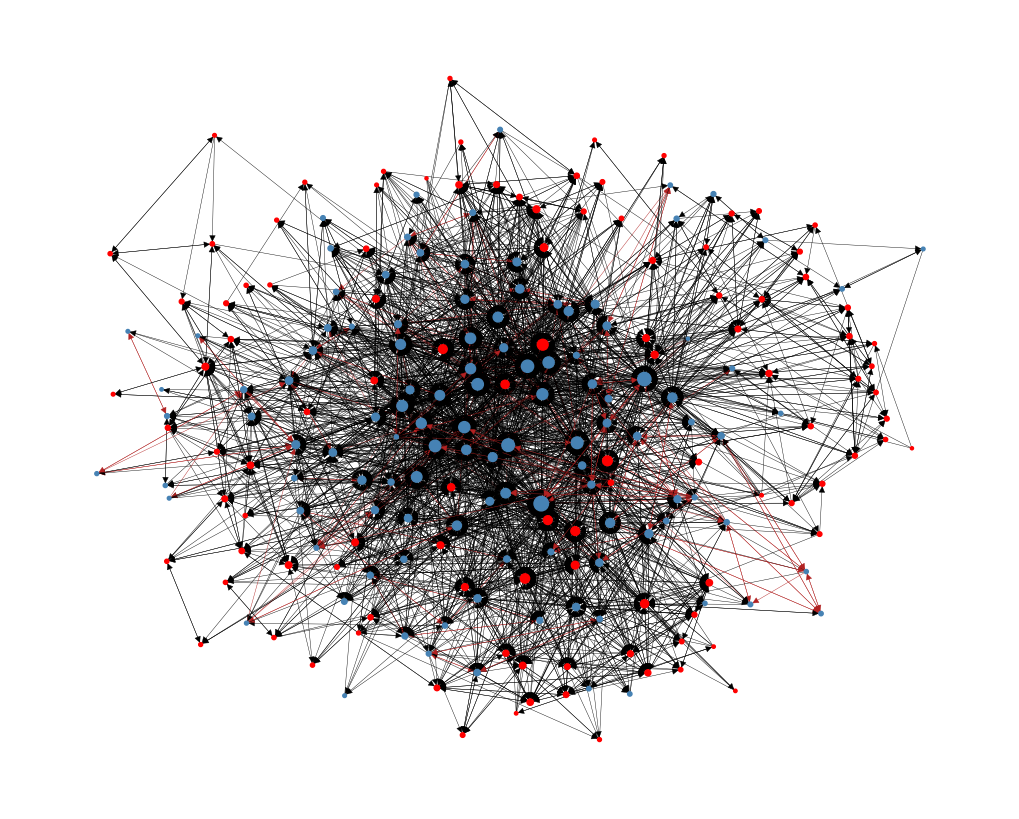

In [66]:
# make a color pallet for the houses
num_houses = len(houses)


colors = ['red' if di_G.nodes[node]['houses']=='No house' else 'steelblue' for node in di_G]


node_sizes = [di_G.in_degree(node)+5 for node in di_G]

edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1 and house_0 != 'No house':
            common_house = True
            break
    
    if common_house:
        edge_colors.append('firebrick')
    else:
        edge_colors.append('black')

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color=colors, edge_color=edge_colors, width=0.3, with_labels=False)
plt.show()

## Degree distributions

In [67]:
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))

print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

<k_in> 16.72398190045249
<k_out> 16.72398190045249
<k_in^2> 564.6606334841629
<k_out^2> 483.6651583710407


In [68]:
N = len(di_G.nodes())
print(f'lnN = {np.log(N)}')

lnN = 5.3981627015177525


min out-degree: 0
max out-degree: 104


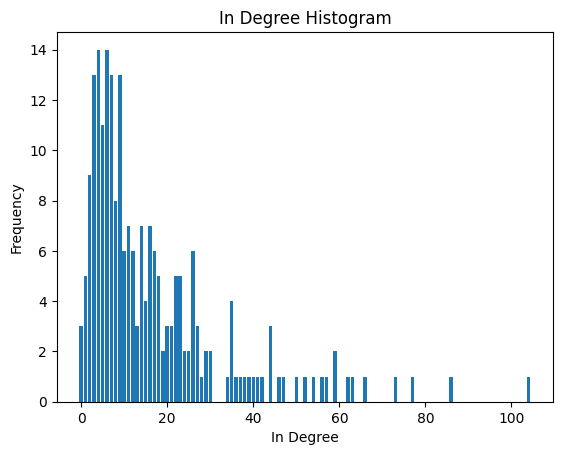

In [69]:
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min out-degree: {min_k_in}')
print(f'max out-degree: {max_k_in}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)
plt.bar(bins_in[:-1], counts_in)

plt.title("In Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("In Degree")
plt.show()

min out-degree: 1
max out-degree: 75


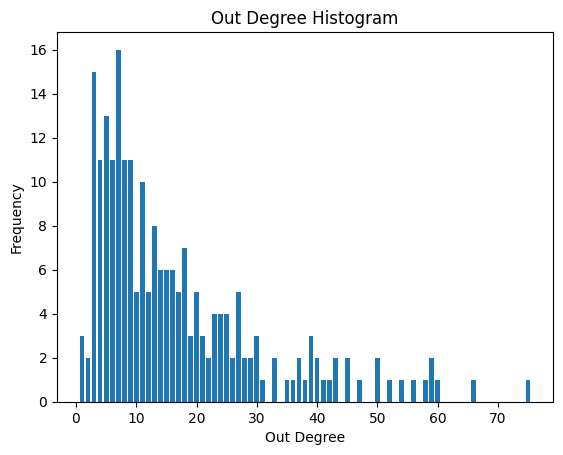

In [70]:
max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

plt.bar(bins_out[:-1], counts_out)
plt.title("Out Degree Histogram")
plt.xlabel("Out Degree")
plt.ylabel("Frequency")
plt.show()

In [71]:
# Powerlaw
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
alpha in: 5.728914491967016
alpha out: 3.084279722382427


Values less than or equal to 0 in data. Throwing out 0 or negative values


### Ohter network statistics

In [72]:
# Get house sizes
house_sizes = {}
for house in houses:
    house_sizes[house] = 0

for name in characters:
    houses_list = characters[name]
    for house in houses_list:
        house_sizes[house] += 1

# sort house sizes
house_sizes = dict(sorted(house_sizes.items(), key=lambda x: x[1], reverse=True))
print(house_sizes)

{'No house': 107, 'House Stark': 11, 'House Baratheon': 11, 'House Lannister': 9, 'House Targaryen': 7, 'House Frey': 6, 'House Tully': 5, 'House Greyjoy': 5, 'House Tarly': 5, 'House Bolton': 4, 'House Tyrell': 4, 'House Umber': 3, 'House Karstark': 3, 'House Mormont': 3, 'House Reed': 3, 'House Martell': 3, 'House Cassel': 2, 'House Payne': 2, 'House Clegane': 2, 'House Florent': 2, 'House Seaworth': 2, 'House Arryn': 2, 'House Baelish': 2, 'House Waynwood': 2, 'House Glover': 1, 'House Cerwyn': 1, 'House Manderly': 1, 'House Lorch': 1, 'House Tarth': 1, 'House Egen': 1, 'House Royce': 1, 'House Corbray': 1, 'House Redwyne': 1, 'House Kenning': 1, 'House Erenford': 1, "Bronn's house": 1, 'Maegyr family': 1, 'House Selmy': 1, 'House Trant': 1, 'House Dondarrion': 1, 'House Slynt': 1, 'House Stokeworth': 1, 'House Hollard': 1, 'House Thorne': 1, 'House Marsh': 1, 'House Yarwyck': 1, 'House Tollett': 1, 'House Mallister': 1, 'House Strickland': 1, 'House of Nakloz': 1, 'House of Ullhor'

In [95]:
# average text lengths
text_lengths = [di_G.nodes[node]['text_len'] for node in di_G.nodes()]
avg_text_len = np.mean(text_lengths)
print(f'Average text length: {avg_text_len}')

# average text lengths for characters with houses
text_lengths_houses = [di_G_with_house.nodes[node]['text_len'] for node in di_G_with_house.nodes()]
avg_text_len_houses = np.mean(text_lengths_houses)
print(f'Average text length for characters with houses: {avg_text_len_houses}')

# average text lengths for characters without houses
text_lengths_no_houses = [di_G.nodes[node]['text_len'] for node in di_G.nodes() if di_G.nodes[node]['houses']=='No house']
avg_text_len_no_houses = np.mean(text_lengths_no_houses)
print(f'Average text length for characters without houses: {avg_text_len_no_houses}')

Average text length: 26345.135746606335
Average text length for characters with houses: 37847.4649122807
Average text length for characters without houses: 14090.317757009347


In [82]:
k_in = sorted((di_G.in_degree), key=lambda x: x[1], reverse=True)
k_out = sorted((di_G.out_degree), key=lambda x: x[1], reverse=True)
print(k_in[:5])
print(k_out[:5])

# weighted degrees by text length
k_in_weighted = sorted([(node, di_G.in_degree[node]/di_G.nodes[node]['text_len']) for node in di_G.nodes()], key=lambda x: x[1], reverse=True)
k_out_weighted = sorted([(node, di_G.out_degree[node]/di_G.nodes[node]['text_len']) for node in di_G.nodes()], key=lambda x: x[1], reverse=True)

print(k_in_weighted[:5])
print(k_out_weighted[:5])

[('Jon Snow', 104), ('Daenerys Targaryen', 86), ('Eddard Stark', 77), ('Tyrion Lannister', 73), ('Stannis Baratheon', 66)]
[('Jon Snow', 75), ('Tyrion Lannister', 66), ('Jaime Lannister', 60), ('Sansa Stark', 59), ('Arya Stark', 59)]
[('Khal', 0.014), ('Archmaester', 0.004429678848283499), ('Ned Umber', 0.0021966880702940185), ('Prendahl na Ghezn', 0.00208955223880597), ('Amory Lorch', 0.0018250134192163178)]
[('Wolkan', 0.0023745612223828204), ('Gerold Hightower', 0.0019214932747735384), ('Caleotte', 0.001782001782001782), ('Old Nan', 0.0017507002801120449), ('Robett Glover', 0.001665657177468201)]


## Word clouds

In [97]:
houses_file_names = []
no_houses_file_names = []
for node in di_G.nodes():
    # save text to file
    file_name = node + '.txt'
    houses_list = di_G.nodes[node]['houses']
    if houses_list == 'No house':
        no_houses_file_names.append(file_name)
    else:
        houses_file_names.append(file_name)

houses_corpus = PlaintextCorpusReader('files/wiki_texts', houses_file_names)

no_houses_corpus = PlaintextCorpusReader('files/wiki_texts', no_houses_file_names)

houses_raw = houses_corpus.raw()
no_houses_raw = no_houses_corpus.raw()


In [134]:
def get_TFTR(text1, text2, c = 1, weighted = False):

    stopwords = nltk.corpus.stopwords.words('english')

    text1_tokens = word_tokenize(text1)
    text1_words = [w.lower() for w in text1_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]

    text2_tokens = word_tokenize(text2)
    text2_words = [w.lower() for w in text2_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    
    if weighted:
        #r1 = len(text2_words)/len(text1_words)
        #r2 = len(text1_words)/len(text2_words)
        r1 = 1/len(text1_words)
        r2 = 1/len(text2_words)
    else:
        r1 = 1
        r2 = 1

    fdist1 = FreqDist(text1_words)
    fdist2 = FreqDist(text2_words)

    dict1_TFTR = dict()
    dict2_TFTR = dict()

    for w in fdist1:
        if w in fdist2:
            weight1 = fdist1[w]*r1/(fdist2[w]*r2+c)
        else:
            weight1 = fdist1[w]*r1/c
        dict1_TFTR[w] = weight1*fdist1[w]
        
    for w in fdist2:
        if w in fdist1:
            weight2 = fdist2[w]*r2/(fdist1[w]*r1+c)
        else:
            weight2 = fdist2[w]*r2/c
        dict2_TFTR[w] = weight2*fdist2[w]

    dict1_TFTR = dict(sorted(dict1_TFTR.items(), key=lambda x:x[1], reverse=True))
    dict2_TFTR = dict(sorted(dict2_TFTR.items(), key=lambda x:x[1], reverse=True))

    return dict1_TFTR, dict2_TFTR, fdist1, fdist2


In [135]:
dict_houses_TFTR, dict_no_houses_TFTR, fdist_houses, fdist_no_houses = get_TFTR(houses_raw, no_houses_raw, c = 1)

houses_str = ""
no_houses_str = ""

for w in dict_houses_TFTR:
    for i in range(int(dict_houses_TFTR[w])):
        houses_str += w + " "

for w in dict_no_houses_TFTR:
    for i in range(int(dict_no_houses_TFTR[w])):
        no_houses_str += w + " "

dict_houses_TFTR_weighted, dict_no_houses_TFTR_weighted, _, _ = get_TFTR(houses_raw, no_houses_raw, c = 1, weighted=True)

houses_str_weighted = ""
no_houses_str_weighted = ""

for w in dict_houses_TFTR_weighted:
    for i in range(int(dict_houses_TFTR_weighted[w])):
        houses_str_weighted += w + " "

for w in dict_no_houses_TFTR_weighted:
    for i in range(int(dict_no_houses_TFTR_weighted[w])):
        no_houses_str_weighted += w + " "

In [136]:
print("Top 5 words in the text from the characters with houses")
for i, w in enumerate(fdist_houses):
    if i >= 10:
        break
    print(w, fdist_houses[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with houses")
for i, w in enumerate(dict_houses_TFTR):
    if i >= 10:
        break
    print(w, dict_houses_TFTR[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with houses")
for i, w in enumerate(dict_houses_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_houses_TFTR_weighted[w])


print("\nTop 5 words in the text from the characters with no house")
for i, w in enumerate(fdist_no_houses):
    if i >= 10:
        break
    print(w, fdist_no_houses[w])
    
        
print("\nTop 5 TF-TR scores in the text from the characters with no house")
for i, w in enumerate(dict_no_houses_TFTR):
    if i >= 10:
        break
    print(w, dict_no_houses_TFTR[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with no house")
for i, w in enumerate(dict_no_houses_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_no_houses_TFTR_weighted[w])
    

Top 5 words in the text from the characters with houses
jon 3275
king 2592
house 2569
tyrion 2539
season 2395
cersei 2179
sansa 2170
daenerys 2124
jaime 2098
stark 2035

Top 5 TF-TR scores in the text from the characters with houses
rhaegar 37889.28571428571
robb 29835.57142857143
kingsguard 21395.571428571428
lyanna 21120.363636363636
jaime 20860.682464454974
sansa 19539.004149377593
joffrey 16761.225225225226
robert 15956.54368932039
stark 12398.877245508982
catelyn 11880.692307692307

Top 5 weighted TF-TR scores in the text from the characters with houses
jon 29.63800079514949
king 18.611657183699602
house 18.30272139934137
tyrion 17.861597914581004
season 15.814606865713047
cersei 13.18233191864449
sansa 13.093278015568094
daenerys 12.479270968695332
jaime 12.241776363921572
stark 11.506249793973286

Top 5 words in the text from the characters with no house
season 1301
thrones 1255
game 1200
jon 1018
daenerys 887
king 704
tyrion 681
night 642
file 629
house 568

Top 5 TF-TR scores 

In [ ]:
dict_Stark_TFTR, dict_no_houses_TFTR, fdist_houses, fdist_no_houses = get_TFTR(houses_raw, no_houses_raw, c = 1)

houses_str = ""
no_houses_str = ""

for w in dict_houses_TFTR:
    for i in range(int(dict_houses_TFTR[w])):
        houses_str += w + " "

for w in dict_no_houses_TFTR:
    for i in range(int(dict_no_houses_TFTR[w])):
        no_houses_str += w + " "

dict_houses_TFTR_weighted, dict_no_houses_TFTR_weighted, _, _ = get_TFTR(houses_raw, no_houses_raw, c = 1, weighted=True)

houses_str_weighted = ""
no_houses_str_weighted = ""

for w in dict_houses_TFTR_weighted:
    for i in range(int(dict_houses_TFTR_weighted[w])):
        houses_str_weighted += w + " "

for w in dict_no_houses_TFTR_weighted:
    for i in range(int(dict_no_houses_TFTR_weighted[w])):
        no_houses_str_weighted += w + " "

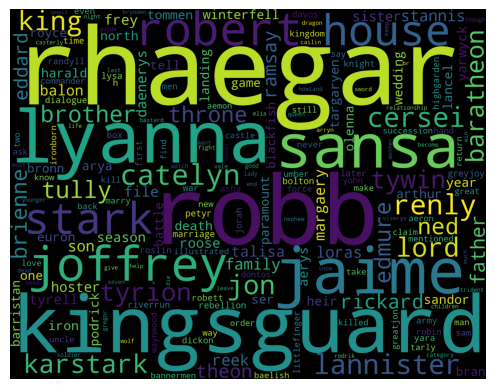

In [137]:
houses_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(houses_str)

plt.imshow(houses_wordcloud)
plt.axis('off')
plt.show()

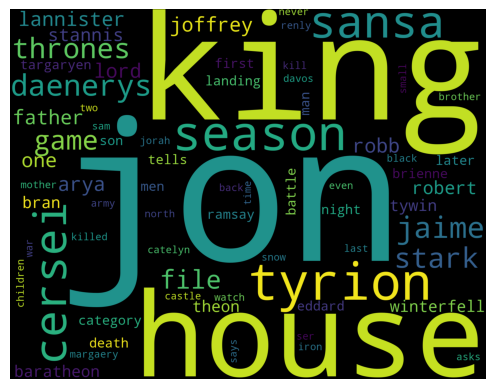

In [138]:
houses_wordcloud_weighted = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(houses_str_weighted)

plt.imshow(houses_wordcloud_weighted)
plt.axis('off')
plt.show()

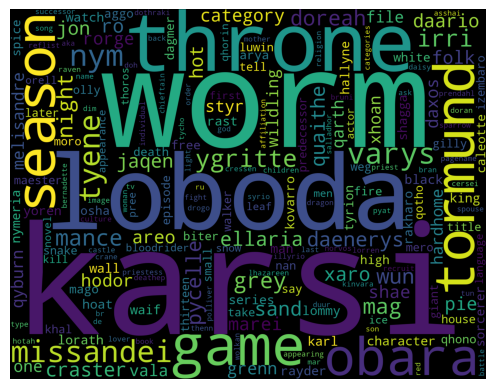

In [139]:
no_houses_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(no_houses_str)

plt.imshow(no_houses_wordcloud)
plt.axis('off')
plt.show()

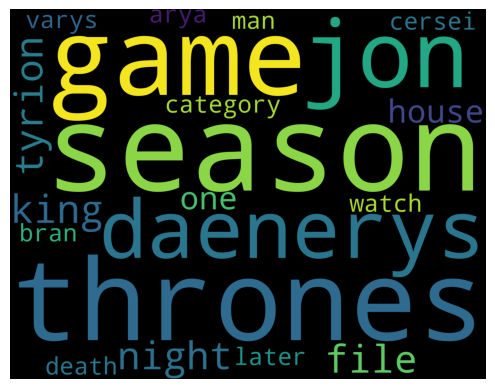

In [140]:
no_houses_wordcloud_weighted = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(no_houses_str_weighted)

plt.imshow(no_houses_wordcloud_weighted)
plt.axis('off')
plt.show()

## Communities

In [141]:
G = di_G.to_undirected()

In [145]:
best_partition = community.best_partition(G, random_state = 42)
print(f'Number of communities: {len(set(best_partition.values()))}')

Number of communities: 6


In [146]:
best_M = community.modularity(best_partition, G)
print(best_M)

0.333860618631622


In [147]:
count_best_communities = dict(FreqDist(list(best_partition.values())))
count_best_communities = dict(sorted(count_best_communities.items(), key=lambda x:x[1], reverse=True))
print(count_best_communities)

{2: 52, 5: 52, 1: 49, 0: 35, 3: 24, 4: 9}


In [150]:
birth_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses):
    dict_houses[house] = i

for node in G.nodes():
    birth_house = G.nodes[node]['houses'].split(', ')[0]
    birth_house_partition[node] = dict_houses[birth_house]
    
birth_house_M = community.modularity(birth_house_partition, G)
print(birth_house_M)

0.05191471483292706


In [151]:
last_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses):
    dict_houses[house] = i

for node in G.nodes():
    last_house = G.nodes[node]['houses'].split(', ')[-1]
    last_house_partition[node] = dict_houses[last_house]
    
last_house_M = community.modularity(last_house_partition, G)
print(last_house_M)

0.05593082408514889


In [153]:
second_house_partition = {}
dict_houses = {}
for i, house in enumerate(houses):
    dict_houses[house] = i

for node in G.nodes():
    try:
        second_house = G.nodes[node]['houses'].split(', ')[1]
    except:
        second_house = G.nodes[node]['houses']
    second_house_partition[node] = dict_houses[second_house]
    
second_house_M = community.modularity(first_second_partition, G)
print(second_house_M)

0.055031037563021384
